In [1]:
file_path = '/Users/tanmaysagarhuria/Downloads/filtered_data_mimed0101.csv'

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [5]:
df = pd.read_csv(file_path)

In [6]:
print(df)

       Type  adjusted_time_ints     adjusted_time       Price     Volume
0       ask                 0.0   0 days 00:00:00  258.684211   2.000000
1       ask                 1.0   0 days 00:01:00  254.000000   5.000000
2       ask                 2.0   0 days 00:02:00  258.000000   1.000000
3       ask                 3.0   0 days 00:03:00  259.000000   4.000000
4       ask                 4.0   0 days 00:04:00  261.000000   2.000000
...     ...                 ...               ...         ...        ...
127495  bid             63745.0  44 days 06:25:00  112.000000   1.928571
127496  bid             63746.0  44 days 06:26:00  112.000000   2.600000
127497  bid             63747.0  44 days 06:27:00  113.000000   4.000000
127498  bid             63748.0  44 days 06:28:00  113.000000  10.000000
127499  bid             63749.0  44 days 06:29:00  112.000000   2.625000

[127500 rows x 5 columns]


In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

In [8]:
# Split into asks and bids
df_asks = df[df['Type'] == 'ask'].drop(columns=['Type'])
df_bids = df[df['Type'] == 'bid'].drop(columns=['Type'])

In [9]:
# Normalize the data
scaler_price = MinMaxScaler(feature_range=(0, 1))
scaler_volume = MinMaxScaler(feature_range=(0, 1))

df_asks['Price'] = scaler_price.fit_transform(df_asks[['Price']])
df_asks['Volume'] = scaler_volume.fit_transform(df_asks[['Volume']])

df_bids['Price'] = scaler_price.transform(df_bids[['Price']])
df_bids['Volume'] = scaler_volume.transform(df_bids[['Volume']])

In [10]:
# We'll need to reset index to align with the transformed data
df_asks.reset_index(drop=True, inplace=True)
df_bids.reset_index(drop=True, inplace=True)
print(df)

       Type  adjusted_time_ints     adjusted_time       Price     Volume
0       ask                 0.0   0 days 00:00:00  258.684211   2.000000
1       ask                 1.0   0 days 00:01:00  254.000000   5.000000
2       ask                 2.0   0 days 00:02:00  258.000000   1.000000
3       ask                 3.0   0 days 00:03:00  259.000000   4.000000
4       ask                 4.0   0 days 00:04:00  261.000000   2.000000
...     ...                 ...               ...         ...        ...
127495  bid             63745.0  44 days 06:25:00  112.000000   1.928571
127496  bid             63746.0  44 days 06:26:00  112.000000   2.600000
127497  bid             63747.0  44 days 06:27:00  113.000000   4.000000
127498  bid             63748.0  44 days 06:28:00  113.000000  10.000000
127499  bid             63749.0  44 days 06:29:00  112.000000   2.625000

[127500 rows x 5 columns]


In [11]:
# Define sequence creation function
def create_sequences(values, time_steps=60):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i:(i + time_steps)])
    return np.stack(output)

In [13]:
def create_sequences(values, time_steps=60):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i:(i + time_steps)])
    return np.stack(output)

In [15]:
# Prepare the data for LSTMs
time_steps = 60
X_asks = create_sequences(df_asks[['Price', 'Volume']].values, time_steps)
X_bids = create_sequences(df_bids[['Price', 'Volume']].values, time_steps)

y_asks = df_asks['Price'][time_steps:].values
y_bids = df_bids['Price'][time_steps:].values

In [16]:
# Train-test split
X_train_asks, X_test_asks, y_train_asks, y_test_asks = train_test_split(X_asks, y_asks, test_size=0.2, random_state=42)
X_train_bids, X_test_bids, y_train_bids, y_test_bids = train_test_split(X_bids, y_bids, test_size=0.2, random_state=42)

In [17]:
# Build the LSTM models
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(1))  # Output layer: one neuron for predicting the price
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [18]:
# Create models for asks and bids
model_asks = create_lstm_model((X_train_asks.shape[1], X_train_asks.shape[2]))
model_bids = create_lstm_model((X_train_bids.shape[1], X_train_bids.shape[2]))


/Users/tanmaysagarhuria/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))  # Output layer: one neuron for predicting the price
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Use the function to create models
# The input shape should be the shape of a single sample (without the batch size)
model_asks = create_lstm_model((X_train_asks.shape[1], X_train_asks.shape[2]))
model_bids = create_lstm_model((X_train_bids.shape[1], X_train_bids.shape[2]))

In [21]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [23]:
def build_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                   input_shape=(X_train_asks.shape[1], X_train_asks.shape[2]),
                   return_sequences=True))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                   return_sequences=False))
    model.add(Dense(1))
    
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
    
    return model

In [24]:
# Instantiate the tuner
tuner = kt.Hyperband(
    build_lstm_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='lstm_tuning',
    project_name='ask_price_tuning'
)

In [26]:
# Include the early stopping callback to avoid unnecessary training time
stop_early = EarlyStopping(monitor='val_loss', patience=5)

# Execute the hyperparameter search
tuner.search(X_train_asks, y_train_asks,
             epochs=20,
             validation_data=(X_test_asks, y_test_asks),
             callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hp
model = tuner.hypermodel.build(best_hps)
model.fit(X_train_asks, y_train_asks, epochs=20, validation_data=(X_test_asks, y_test_asks))

Trial 30 Complete [00h 45m 33s]
val_loss: 0.00040256738429889083

Best val_loss So Far: 0.00036794235347770154
Total elapsed time: 14h 34m 12s
Epoch 1/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 416s 261ms/step - loss: 0.0026 - val_loss: 3.8749e-04
Epoch 2/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 404s 253ms/step - loss: 4.3275e-04 - val_loss: 4.1312e-04
Epoch 3/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 400s 251ms/step - loss: 4.3719e-04 - val_loss: 3.7960e-04
Epoch 4/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 405s 254ms/step - loss: 4.2151e-04 - val_loss: 5.2951e-04
Epoch 5/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 407s 256ms/step - loss: 4.2472e-04 - val_loss: 3.9134e-04
Epoch 6/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 405s 254ms/step - loss: 4.1363e-04 - val_loss: 3.9010e-04
Epoch 7/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 407s 255ms/step - loss: 4.0778e-04 - val_loss: 3.8512e-04
Epoch 8/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 394s 248ms/step - loss: 4.0188e-04 - val_loss: 4.2750e-04
Epoch 9/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 404s 254ms/step - l

The Hyperband tuner in keras-tuner adjusts the number of trials dynamically based on the max_epochs and the factor parameters. It is not fixed like in a grid search or random search. Instead, Hyperband uses a sports championship style bracketing to run multiple shorter trials and only promotes the top-performing models to the next round.

To determine the number of models that are trained, Hyperband computes the maximum number of brackets (s_max) possible and runs s_max + 1 actual brackets. The number of models in the first bracket is factor^(s_max) * eta^0, where eta is the downscaling factor for each bracket, and this value decreases for each subsequent bracket.

To calculate the actual number of trials that will be executed, you would use the formula from the original Hyperband paper, which is a bit involved, but essentially, it depends on these parameters and the number of hyperband_iterations you specify. The total number of models evaluated will be less than or equal to the product of max_epochs and hyperband_iterations.

Given the parameters in the example provided:

max_epochs=20
factor=3
hyperband_iterations=2 (if this was set, by default it's 1)
The maximum number of brackets s_max is computed internally based on max_epochs and factor. For each bracket, the number of models trained is reduced progressively, so you won't simply have 20 * 2 models trained.

To get the exact number of trials, you could add a line to print tuner.oracle.get_state()['trials'] after the search is completed,

In [28]:
def build_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                   input_shape=(X_train.shape[1], X_train.shape[2]),  # Make sure X_train includes both price and volume
                   return_sequences=True))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                   return_sequences=False))
    model.add(Dense(1))  # Predicting the next price

    # Learning rate is chosen from a logarithmic scale for a more fine-grained search in lower values
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')

    return model



In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming scaler_price is your MinMaxScaler instance for 'Price'
# and you've retained it after scaling your ask data

# If your model is for 'ask' prices
predictions = model.predict(X_test_asks)
predictions_inversed = scaler_price.inverse_transform(predictions)
y_test_asks_inversed = scaler_price.inverse_transform(y_test_asks.reshape(-1, 1))

# Calculate some metrics
mse = mean_squared_error(y_test_asks_inversed, predictions_inversed)
mae = mean_absolute_error(y_test_asks_inversed, predictions_inversed)

print(f"Test MSE: {mse}")
print(f"Test MAE: {mae}")

399/399 ━━━━━━━━━━━━━━━━━━━━ 42s 104ms/step
Test MSE: 32.89026882598795
Test MAE: 4.892643821402377


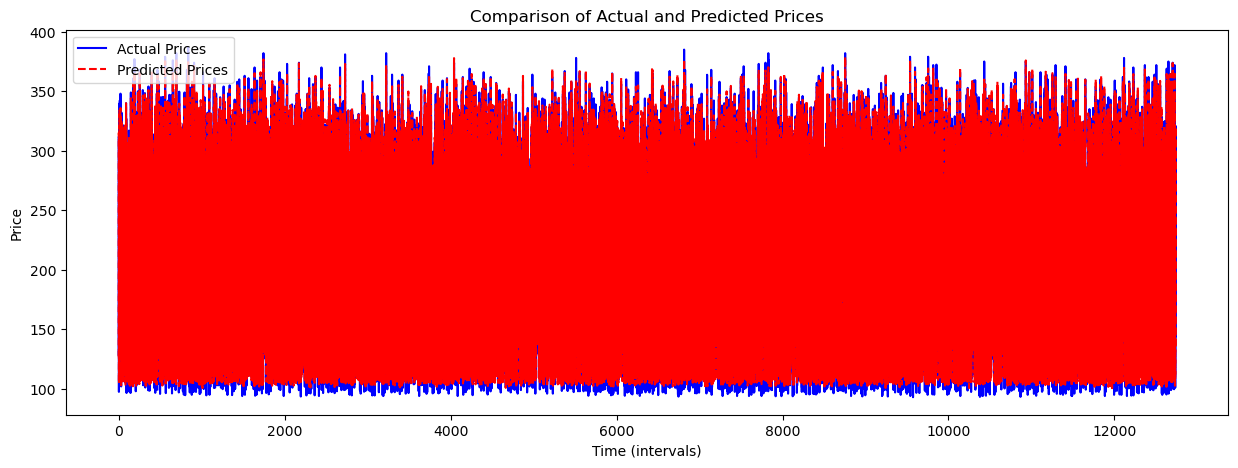

In [35]:
import matplotlib.pyplot as plt

# Plot the actual vs predicted values
plt.figure(figsize=(15, 5))
plt.plot(y_test_asks_inversed, label='Actual Prices', color='blue')
plt.plot(predictions_inversed, label='Predicted Prices', color='red', linestyle='--')
plt.title('Comparison of Actual and Predicted Prices')
plt.xlabel('Time (intervals)')
plt.ylabel('Price')
plt.legend()
plt.show()



In [37]:
look_back = 60

# Extract the timestamps for the test dataset
timestamps_test = df_asks['adjusted_time'][-(len(X_test_asks) + look_back):].reset_index(drop=True)


In [38]:
aligned_timestamps = timestamps_test[look_back:]

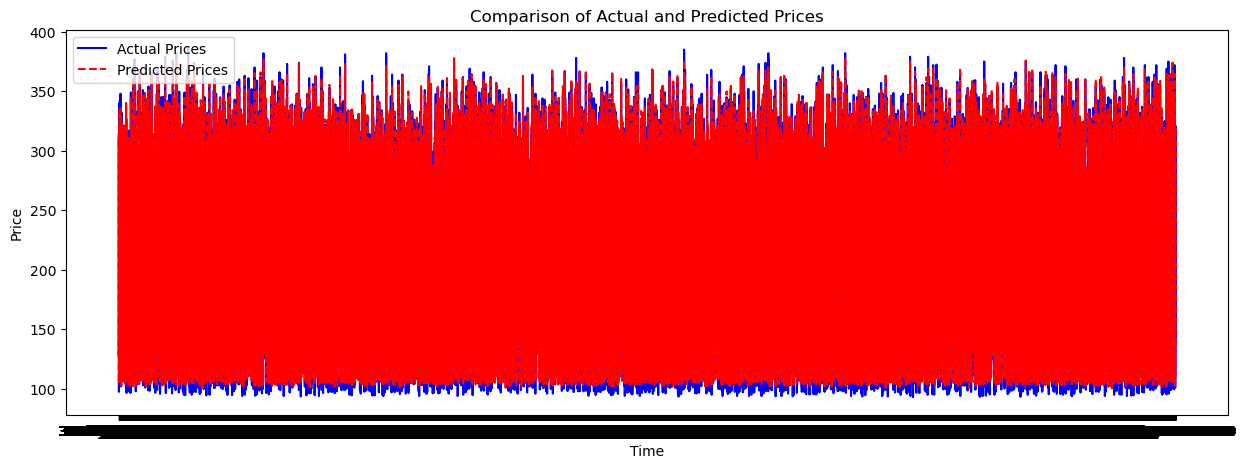

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(aligned_timestamps, y_test_asks_inversed, label='Actual Prices', color='blue')
plt.plot(aligned_timestamps, predictions_inversed, label='Predicted Prices', color='red', linestyle='--')
plt.title('Comparison of Actual and Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [40]:
# Prepare the data for LSTMs
time_steps = 60
X_bids = create_sequences(df_bids[['Price', 'Volume']].values, time_steps)
y_bids = df_bids['Price'][time_steps:].values

In [42]:
# Prepare the data for LSTMs
time_steps = 60
X_bids = create_sequences(df_bids[['Price', 'Volume']].values, time_steps)
y_bids = df_bids['Price'][time_steps:].values

# Train-test split
X_train_bids, X_test_bids, y_train_bids, y_test_bids = train_test_split(X_bids, y_bids, test_size=0.2, random_state=42)

# Create model for bids
model_bids = create_lstm_model((X_train_bids.shape[1], X_train_bids.shape[2]))

/Users/tanmaysagarhuria/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [43]:
model_bids.fit(X_train_bids, y_train_bids, epochs=20, validation_data=(X_test_bids, y_test_bids))

Epoch 1/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - loss: 0.0041 - val_loss: 7.7316e-05
Epoch 2/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 31s 19ms/step - loss: 5.0585e-05 - val_loss: 4.0313e-05
Epoch 3/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - loss: 5.6903e-05 - val_loss: 2.8512e-05
Epoch 4/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - loss: 4.7308e-05 - val_loss: 2.8776e-05
Epoch 5/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - loss: 4.2638e-05 - val_loss: 3.4315e-05
Epoch 6/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - loss: 3.8779e-05 - val_loss: 2.6874e-05
Epoch 7/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 31s 19ms/step - loss: 3.7373e-05 - val_loss: 3.1069e-05
Epoch 8/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 31s 19ms/step - loss: 3.3207e-05 - val_loss: 7.8686e-05
Epoch 9/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 31s 19ms/step - loss: 3.8896e-05 - val_loss: 6.5247e-05
Epoch 10/20
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 31s 19ms/step - loss: 3.1801e-05 - val_loss: 2.4738e-05
Epoch 11/20
1593/1593 ━

In [46]:
# Make predictions for the bid prices
predictions_bids = model_bids.predict(X_test_bids)

399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [47]:
predictions_bids_inversed = scaler_price.inverse_transform(predictions_bids)
y_test_bids_inversed = scaler_price.inverse_transform(y_test_bids.reshape(-1, 1))

In [48]:
timestamps_test_bids = df_bids['adjusted_time'][len(df_bids) - len(X_test_bids) - time_steps:].reset_index(drop=True)[time_steps:]

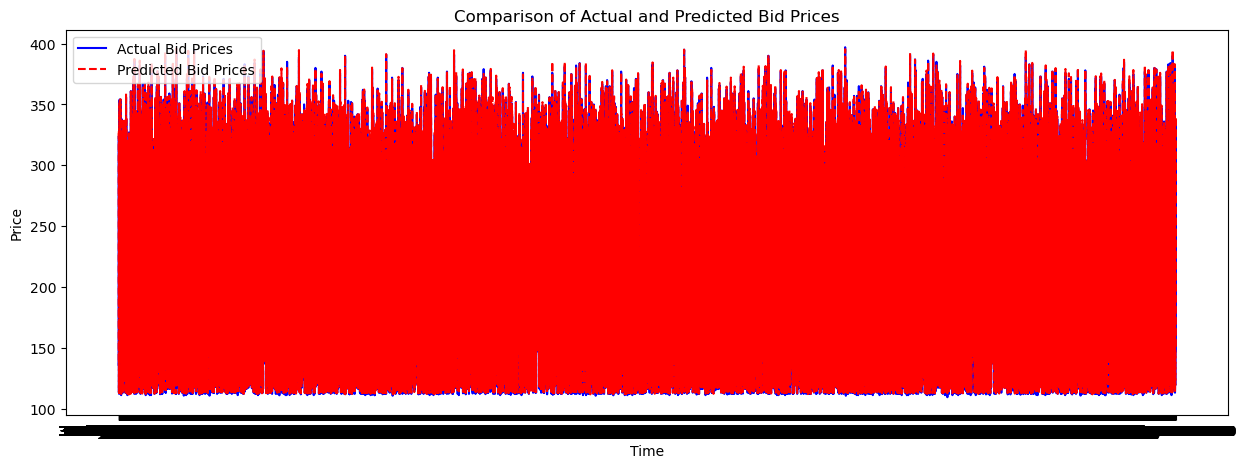

In [49]:
plt.figure(figsize=(15, 5))
plt.plot(timestamps_test_bids, y_test_bids_inversed, label='Actual Bid Prices', color='blue')
plt.plot(timestamps_test_bids, predictions_bids_inversed, label='Predicted Bid Prices', color='red', linestyle='--')
plt.title('Comparison of Actual and Predicted Bid Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [52]:
# Assuming you've trained your model and named it 'model_asks'
# And 'scaler_price' is the scaler used to normalize the 'Price' column
# Predict ask prices using the test set
predictions_asks = model_asks.predict(X_test_asks)

# Inverse scale the predictions
predictions_asks_inversed = scaler_price.inverse_transform(predictions_asks)

# Ensure you also have the inverse transformed 'y_test_asks' and 'y_test_bids' ready
y_test_asks_inversed = scaler_price.inverse_transform(y_test_asks.reshape(-1, 1))
y_test_bids_inversed = scaler_price.inverse_transform(y_test_bids.reshape(-1, 1))

# Now, you can use predictions_asks_inversed in your trading loop


399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


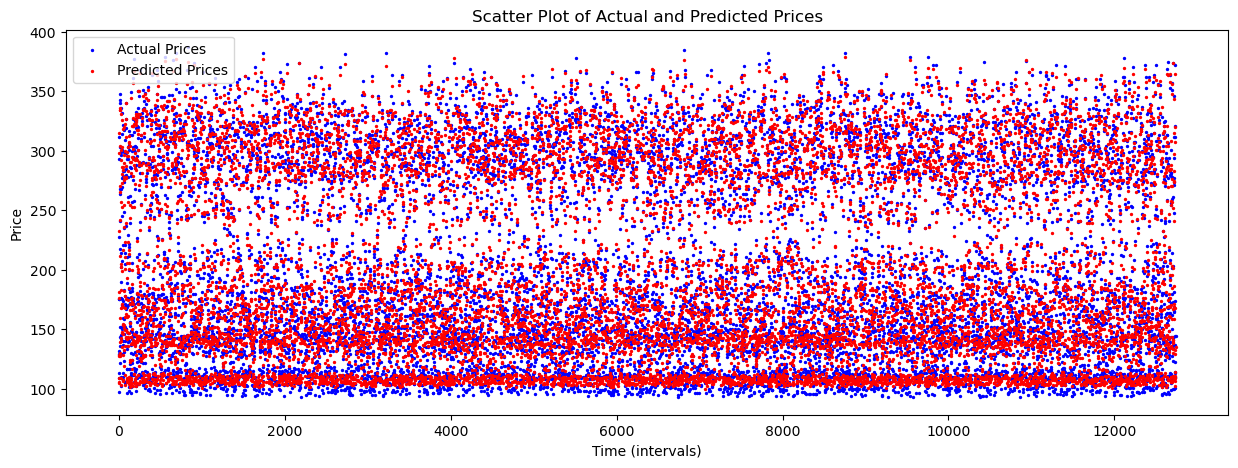

In [55]:
# Scatter plot of actual vs predicted prices
plt.figure(figsize=(15, 5))
plt.scatter(range(len(y_test_asks_inversed)), y_test_asks_inversed, color='blue', label='Actual Prices', s=2)
plt.scatter(range(len(predictions_inversed)), predictions_inversed, color='red', label='Predicted Prices', s=2)
plt.title('Scatter Plot of Actual and Predicted Prices')
plt.xlabel('Time (intervals)')
plt.ylabel('Price')
plt.legend()
plt.show()


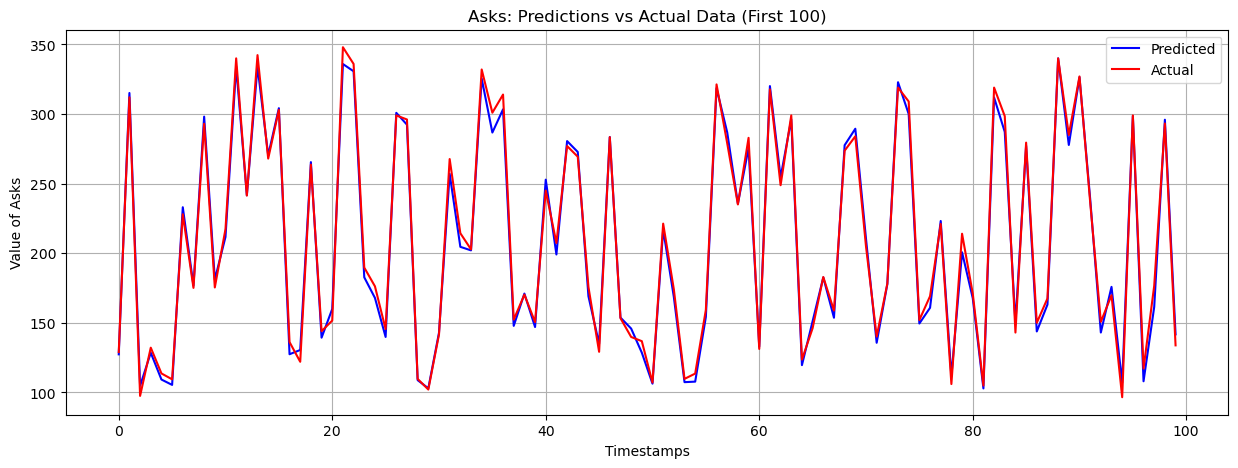

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(predictions_inversed[:100], color= 'blue' , label='Predicted')
plt.plot(y_test_asks_inversed[:100], color='red', label='Actual')
plt.title('Asks: Predictions vs Actual Data (First 100)')
plt.xlabel('Timestamps')
plt.ylabel('Value of Asks')
plt.legend()
plt.grid(True)
plt.show()



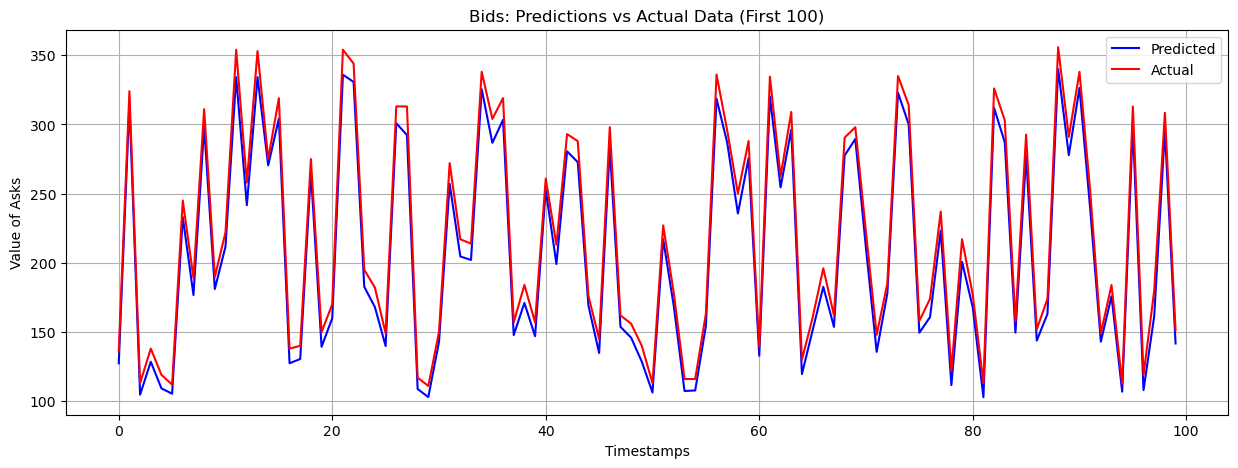

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(predictions_inversed[:100], color= 'blue' , label='Predicted')
plt.plot(y_test_bids_inversed[:100], color='red', label='Actual')
plt.title('Bids: Predictions vs Actual Data (First 100)')
plt.xlabel('Timestamps')
plt.ylabel('Value of Asks')
plt.legend()
plt.grid(True)
plt.show()


In [82]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import het_breuschpagan

In [87]:
import pandas as pd
import matplotlib.pyplot as plt

In [92]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [93]:
mae = mean_absolute_error(y_test_asks_inversed, predictions_asks_inversed)
mse = mean_squared_error(y_test_asks_inversed, predictions_asks_inversed)
r2 = r2_score(y_test_asks_inversed, predictions_asks_inversed)

In [94]:
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Coefficient of Determination (R^2): {r2}")

Mean Absolute Error (MAE): 95.70672870022707
Mean Squared Error (MSE): 14340.736887819483
Coefficient of Determination (R^2): -1.2016635160888622


In [95]:
def directional_accuracy(true_values, predictions):
    # Define the correct direction count
    correct_direction = 0
    for i in range(1, len(true_values)):
        # Compare the direction of the actual value vs the previous value, to the prediction vs the previous actual value
        if (true_values[i] - true_values[i-1]) * (predictions[i] - true_values[i-1]) > 0:
            correct_direction += 1
    
    # Calculate the accuracy as the percentage of correct direction predictions
    return correct_direction / (len(true_values) - 1)

# Calculate the directional accuracy
dir_acc = directional_accuracy(y_test_asks_inversed.flatten(), predictions_asks_inversed.flatten())
print(f"Directional Accuracy: {dir_acc:.2f}")

Directional Accuracy: 0.57


In [107]:
print(df)

       Type  adjusted_time_ints     adjusted_time  Price     Volume  \
49      ask                49.0   0 days 00:49:00  251.0   1.000000   
50      ask                50.0   0 days 00:50:00  248.0   2.500000   
51      ask                51.0   0 days 00:51:00  247.0   1.000000   
52      ask                52.0   0 days 00:52:00  245.0   3.000000   
53      ask                53.0   0 days 00:53:00  244.0   2.714286   
...     ...                 ...               ...    ...        ...   
127495  bid             63745.0  44 days 06:25:00  112.0   1.928571   
127496  bid             63746.0  44 days 06:26:00  112.0   2.600000   
127497  bid             63747.0  44 days 06:27:00  113.0   4.000000   
127498  bid             63748.0  44 days 06:28:00  113.0  10.000000   
127499  bid             63749.0  44 days 06:29:00  112.0   2.625000   

             MA_10       MA_50        RSI      MACD  Signal_Line     RSI_14  
49      251.816400  254.903637  50.313875  0.000000     0.000000  57.

In [114]:
df.drop('MA_10', axis=1, inplace=True)

In [115]:
df.drop('MA_50', axis=1, inplace=True)

In [116]:
df.drop('RSI', axis=1, inplace=True)

In [117]:
df.drop('MACD', axis=1, inplace=True)

In [118]:
df.drop('Signal_Line', axis=1, inplace=True)

In [119]:
df.drop('RSI_14', axis=1, inplace=True)

In [128]:
df.drop('signal', axis=1, inplace=True)

In [129]:
print(df)

       Type  adjusted_time_ints     adjusted_time  Price     Volume
49      ask                49.0   0 days 00:49:00  251.0   1.000000
50      ask                50.0   0 days 00:50:00  248.0   2.500000
51      ask                51.0   0 days 00:51:00  247.0   1.000000
52      ask                52.0   0 days 00:52:00  245.0   3.000000
53      ask                53.0   0 days 00:53:00  244.0   2.714286
...     ...                 ...               ...    ...        ...
127495  bid             63745.0  44 days 06:25:00  112.0   1.928571
127496  bid             63746.0  44 days 06:26:00  112.0   2.600000
127497  bid             63747.0  44 days 06:27:00  113.0   4.000000
127498  bid             63748.0  44 days 06:28:00  113.0  10.000000
127499  bid             63749.0  44 days 06:29:00  112.0   2.625000

[125274 rows x 5 columns]


In [126]:
%whos

Variable                    Type               Data/Info
--------------------------------------------------------
Adam                        type               <class 'keras.src.optimizers.adam.Adam'>
Dense                       type               <class 'keras.src.layers.core.dense.Dense'>
EarlyStopping               type               <class 'keras.src.callbac<...>_stopping.EarlyStopping'>
LSTM                        type               <class 'keras.src.layers.rnn.lstm.LSTM'>
MinMaxScaler                type               <class 'sklearn.preproces<...>sing._data.MinMaxScaler'>
Sequential                  type               <class 'keras.src.models.sequential.Sequential'>
X_asks                      ndarray            63690x60x2: 7642800 elems, type `float64`, 61142400 bytes (58.3099365234375 Mb)
X_bids                      ndarray            63690x60x2: 7642800 elems, type `float64`, 61142400 bytes (58.3099365234375 Mb)
X_test_asks                 ndarray            12738x60x2: 1528

In [127]:
# Assuming 'df' is your DataFrame
print(df.columns.tolist())


['Type', 'adjusted_time_ints', 'adjusted_time', 'Price', 'Volume', 'signal']


In [130]:
import pandas as pd

short_window = 24000
long_window = 60000

df['SMA_short'] = df['Price'].rolling(window=short_window, min_periods=1).mean()
df['SMA_long'] = df['Price'].rolling(window=long_window, min_periods=1).mean()

df['Buy_Signal'] = (df['SMA_short'] > df['SMA_long']) & (df['SMA_short'].shift(1) <= df['SMA_long'].shift(1))


df['Sell_Signal'] = (df['SMA_short'] < df['SMA_long']) & (df['SMA_short'].shift(1) >= df['SMA_long'].shift(1))


signals_df = df.loc[df['Buy_Signal'] | df['Sell_Signal']]

print(signals_df[['Price', 'SMA_short', 'SMA_long', 'Buy_Signal', 'Sell_Signal']])


         Price   SMA_short    SMA_long  Buy_Signal  Sell_Signal
24049   213.45  295.007625  295.005792        True        False
25492   185.75  290.426725  290.427228       False         True
73300   361.00  195.410007  195.403486        True        False
103279  177.00  209.847674  209.851026       False         True
